In [1]:
# MNIST
#
# characteristics:
#    ensembled CNN
#    29700 parameters 
#    input trained with 5% noise
#    parametrized neural network generation
# 
# results:
#    val_acc: 0.9935%
#
# 2019/08/06 by srivera

import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras import backend as K
from keras import activations
import pandas as pd
import numpy as np 
from keras.models import Model, Input
from keras.layers import Dense, Dropout, Flatten, Concatenate, Reshape, concatenate, Maximum, Permute
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D, MaxPooling1D
import keras.utils.np_utils as kutils
from keras.utils import np_utils, plot_model

batch_size = 128
num_classes = 10
epochs = 200 # 10
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

NOISE = 0.050
x_train = x_train.astype('float32') # la imagen de marsee tiene offset
x_test = x_test.astype('float32')
x_train /= 255
x_train += np.random.normal(0.0,NOISE,x_train.shape) + np.random.normal(0.0,NOISE,1)[0]
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [2]:
type(x_train)

numpy.ndarray

In [3]:
y_train = y_train.astype('int32')
y_test  = y_test.astype('int32')
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.np_utils.to_categorical(y_test, num_classes)

# the goal is to produce a model that is simple
# and composed of submodels not interconnected, 
# except for the input and the output layers 
# (since later I produce digital hardware that 
# runs the NN).

def subModelGenerator():
    subModel=[]
    subModel.append(Input(shape=(28, 28, 1), name="input"))
    Nlayers = 3
    for i in range(Nlayers):
        if i == 0:
            subModel.append(Conv2D(10,(7,7), padding="valid", input_shape=(28, 28,1), 
                               kernel_initializer="glorot_uniform")(subModel[-1]))
        else:
            subModel.append(Conv2D(10,(7-i*2,7-i*2), padding="same", kernel_initializer="glorot_uniform")(subModel[-1]))
            
        subModel.append(Activation(activation='relu')(subModel[-1]))
        subModel.append(MaxPooling2D(pool_size=(2,2))(subModel[-1]))
        
    subModel.append(Flatten()(subModel[-1]))
    subModel.append(Dense(20, kernel_initializer="glorot_uniform")(subModel[-1]))
    subModel.append(Activation(activation='relu')(subModel[-1]))
    subModel.append(Dense(num_classes, kernel_initializer="glorot_uniform")(subModel[-1]))
    subModel.append(Activation(activation='softmax')(subModel[-1]))
    
    model = Model(inputs=subModel[0], outputs=subModel[-1])
    optimizer=keras.optimizers.Adadelta(lr=0.990, rho=0.95, epsilon=None, decay=0.0)#,0.3015
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])
    model.summary()
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test))
    return model

Nsubmodels = 6
models=[]
for i in range(Nsubmodels):
    models.append(subModelGenerator())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 10)        500       
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 10)        2510      
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 10)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 10)          0         
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 10)           4950        input[0][0]                      
__________________________________________________________________________________________________
model_2 (Model)                 (None, 10)           4950        input[0][0]                      
__________________________________________________________________________________________________
model_3 (Model)                 (None, 10)           4950        input[0][0]                      
__________________________________________________________________________________________________
model_4 (M

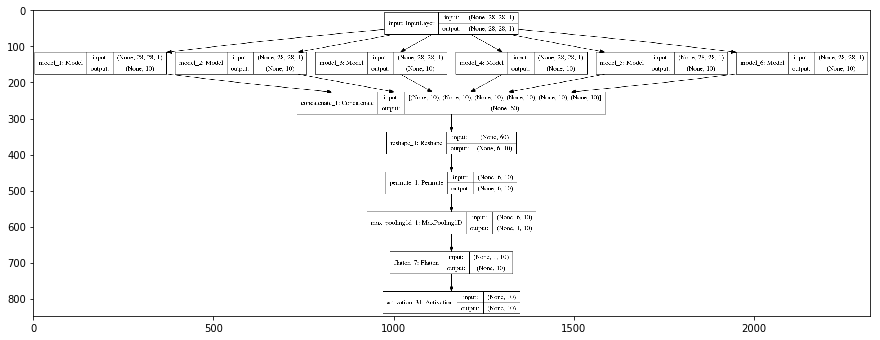

In [4]:
batch_size = 128
epochs = 1

output=[]
B=[]
B.append(Input(shape=(28, 28, 1), name="input"))

for i in range(Nsubmodels):
    A=[]
    for l in models[i].layers:
        l.trainable = False
    A.append(models[i](B[0]))
    A[-1].trainable = False
    output.append(A[-1])
    

B.append(concatenate(output))
B.append(Reshape((Nsubmodels,10))(B[-1]))
B.append(Permute((1, 2))(B[-1]))
B.append(MaxPooling1D(pool_size=(Nsubmodels))(B[-1]))
B.append(Flatten()(B[-1]))
B.append(Activation(activation='softmax')(B[-1]))
model = Model(inputs=B[0],outputs=B[-1])
model.summary()

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(15,60))
x=plt.imread("model.png")
plt.imshow(x)

optimizer=keras.optimizers.Adadelta(lr=0.990, rho=0.95, epsilon=None, decay=0.0)#,0.3015
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test))
# fitting is just for testing, since there NN are already trainned

In [5]:
test= pd.read_csv("../input/digit-recognizer/test.csv")
x_test = test.values.astype('float32')
x_test /= 255.
#final_loss, final_acc = model.evaluate(x_test, y_test, verbose=0)

x_test = x_test.reshape(x_test.shape[0], 28, 28,1)  

print(x_test.shape)

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# prediction
predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(predicted_classes,axis=1)
print(predicted_classes)
# submissions
submissions = pd.DataFrame({"ImageId": list(range(1, len(predicted_classes)+1)),
                           "Label": predicted_classes})
submissions.to_csv("mnistSubmission.csv", index = False, header = True)

# save model
model.save('model.h5')

# json model
json_string = model.to_json()

len(predicted_classes)

(28000, 28, 28, 1)
[2 0 9 ... 3 9 2]


28000

In [6]:
# import kaggle as kg
# kg competitions submit -c digit-recognizer -f mnistSubmission.csv -m "MNIST, ensembled CNN, 29700 parameters, 5 percent noise, parametrized neural network, by srivera"